In [46]:
import os

import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
import numpy as np


### Namen seminarske naloge
V seminarski nalogi boste na izbrani javni bazi podatkov izvedli celoten proces podatkovnega raziskovanja, modeliranja in optimizacije, kot ste ga spoznavali tekom vaj. Vaš cilj je razumeti delovanje izbranega procesa, identificirati pomembne dejavnike, razviti najboljši napovedni model ter pripraviti priporočila za optimizacijo procesa na podlagi rezultatov modeliranja. Nalogo izvajata dva študenta:

- En primer mora biti regresijski (odvisna spremenljivka je numerična). |
- En primer mora biti klasifikacijski (odvisna spremenljivka je binarna). |

Opomba: Od točke 1.4 (Bivariatna analiza) dalje naredite vse ločeno za a) regresijski primer in b) klasifikacijski primer — to bomo označili v nadaljevanju. |

---

### 1.1 Izbor podatkov, namen in cilji analize (Dopolnitev: Opis spremenljivk) |

Spodaj je posodobljen opis spremenljivk glede na novo glavo datoteke (new dataset): |

- `track_id`: Edinstven identifikator skladbe. (Kategorična/string)
- `artists`: Ime izvajalca/izvajalcev skladbe. (Kategorična/string) — včasih več izvajalcev v eni celici.
- `album_name`: Ime albuma, ki vsebuje skladbo. (Kategorična/string)
- `track_name`: Ime skladbe. (Kategorična/string)
- `popularity`: Indeks popularnosti skladbe (0–100). (Numerična/int) — ciljna spremenljivka za regresijski primer; za klasifikacijo bomo definirali binarno različico (npr. visoka/nizka popularnost).
- `duration_ms`: Trajanje skladbe v milisekundah. (Numerična/int) — izpeljana značilka: `duration_min`.
- `explicit`: Ali ima skladba eksplicitno vsebino. (Binarna/kategorčna)
- `danceability`: Kako primerna je skladba za ples (0.0–1.0). (Numerična/float)
- `energy`: Intenzivnost in aktivnost skladbe (0.0–1.0). (Numerična/float)
- `key`: Ključ skladbe (0–11). (Kategorčna/int)
- `loudness`: Glasnost skladbe v decibelih (dB). (Numerična/float)
- `mode`: Mol ali dur (0=mol, 1=dur). (Kategorčna/int)
- `speechiness`: Prisotnost govorjenih besed v skladbi (0.0–1.0). (Numerična/float)
- `acousticness`: Akustičnost skladbe (0.0–1.0). (Numerična/float)
- `instrumentalness`: Prisotnost vokalov v skladbi (0.0–1.0). (Numerična/float)
- `liveness`: Prisotnost občinstva v posnetku (0.0–1.0). (Numerična/float)
- `valence`: Pozitivnost glasbenega tona (0.0–1.0). (Numerična/float)
- `tempo`: Tempo skladbe v BPM (beats per minute). (Numerična/float)
- `time_signature`: Časovna mera (npr. 4/4, 3/4). (Kategorčna/int)
- `track_genre`: Žanr skladbe. (Kategorična/string)
- `duration_min`: Trajanje skladbe v minutah. (Numerična/float) — izpeljana značilka iz `duration_ms`.
- `is_instrumental`: Binarna značilka, ali je skladba instrumentalna (1=Da, 0=Ne). (Kategorčna/int) — izpeljana značilka iz `instrumentalness` (instrumentalness > 0.5).


In [2]:
# 1.1 Izbor podatkov
# Nalaganje podatkov
dataset_path = os.path.join('datasets', 'dataset2.csv')
df = pd.read_csv(dataset_path)

print(f"\nŠtevilo vrstic: {len(df)}")
print(f"Število stolpcev: {len(df.columns)}")

print("\nPrvih 5 vrstic podatkov:")
print(df.head())

print("\nInformacije o podatkovnem okviru:")
df.info()

print("\nStatistični povzetek numeričnih stolpcev:")
print(df.describe())

print("\nPreverjanje manjkajočih vrednosti:")
print(df.isnull().sum())

print("\nPreverjanje duplikatov (na podlagi vseh stolpcev):")
print(f"Število duplikatov: {df.duplicated().sum()}")


Število vrstic: 114000
Število stolpcev: 21

Prvih 5 vrstic podatkov:
   Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False 

In [3]:
# 1.2 Pregled in čiščenje podatkov
df = df.copy()

# Drop duplicates (based on track_id)
df = df.drop_duplicates(subset=['track_id'], keep='first')

# Fill missing genres (common in this dataset — use 'Unknown' or drop)
df['track_genre'] = df['track_genre'].fillna('Unknown')

# Odstrani neimenovan indeksni stolpec (row_id)
if df.columns[0].startswith('Unnamed'):
    df = df.drop(columns=df.columns[0])

# Preverimo, če so ostale še kakšne manjkajoče vrednosti
print("\nManjkajoče vrednosti po čiščenju:")
print(df.isnull().sum())



Manjkajoče vrednosti po čiščenju:
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


In [4]:
# # Extreme values handling
# outliers = {}
#
# num_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]
# df['is_outlier'] = False
# for col in num_cols:
#     Q1 = df[col].quantile(0.25)
#     Q3 = df[col].quantile(0.75)
#     IQR = Q3 - Q1
#
#     lower = Q1 - 1.5 * IQR
#     upper = Q3 + 1.5 * IQR
#
#     outliers[col] = df[(df[col] < lower) | (df[col] > upper)]
#
#     print(f"{col}: {len(outliers[col])} outliers")
#
#     df.loc[(df[col] < lower) | (df[col] > upper), 'is_outlier'] = True


In [6]:
num_cols = df.select_dtypes(include='number').columns

desc_table = pd.DataFrame(index=num_cols)

desc_table['mean'] = df[num_cols].mean()
desc_table['std'] = df[num_cols].std()
desc_table['median'] = df[num_cols].median()
desc_table['Q1'] = df[num_cols].quantile(0.25)
desc_table['Q3'] = df[num_cols].quantile(0.75)
desc_table['min'] = df[num_cols].min()
desc_table['max'] = df[num_cols].max()
desc_table['n'] = df[num_cols].count()

desc_table = desc_table.round(3)
desc_table


mean         std      median          Q1          Q3  \
popularity            33.198      20.581      33.000      19.000      49.000   
duration_ms       229141.812  112947.741  213293.000  173040.000  264293.000   
danceability           0.562       0.177       0.576       0.450       0.692   
energy                 0.634       0.257       0.676       0.457       0.853   
key                    5.284       3.560       5.000       2.000       8.000   
loudness              -8.499       5.221      -7.185     -10.322      -5.108   
mode                   0.637       0.481       1.000       0.000       1.000   
speechiness            0.087       0.113       0.049       0.036       0.086   
acousticness           0.328       0.338       0.188       0.017       0.625   
instrumentalness       0.173       0.324       0.000       0.000       0.098   
liveness               0.217       0.195       0.132       0.098       0.279   
valence                0.469       0.263       0.457       0.249       0.682   
tempo                122.058      30.118     122.013      99.264     140.077   
time_signature         3.897       0.453       4.000       4.000       4.000   

                     min          max      n  
popularity         0.000      100.000  89741  
duration_ms        0.000  5237295.000  89741  
danceability       0.000        0.985  89741  
energy             0.000        1.000  89741  
key                0.000       11.000  89741  
loudness         -49.531        4.532  89741  
mode               0.000        1.000  89741  
speechiness        0.000        0.965  89741  
acousticness       0.000        0.996  89741  
instrumentalness   0.000        1.000  89741  
liveness           0.000        1.000  89741  
valence            0.000        0.995  89741  
tempo              0.000      243.372  89741  
time_signature     0.000        5.000  89741

In [42]:
numeric_cols = [
    'popularity', 'danceability', 'energy', 'loudness',
    'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo'
]

duration = 'duration_ms'

binary_cols = ['explicit', 'mode']
categorical_cols = ['key', 'time_signature', 'track_genre']
text_cols = ['artists', 'album_name', 'track_name']

audio_features = ['danceability', 'energy', 'loudness',
                  'speechiness', 'acousticness', 'instrumentalness',
                  'liveness', 'valence']



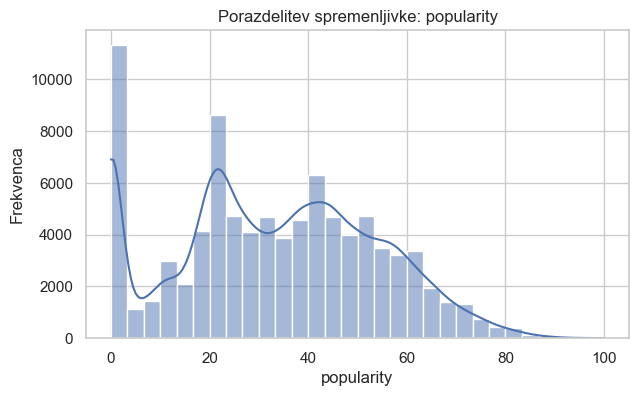

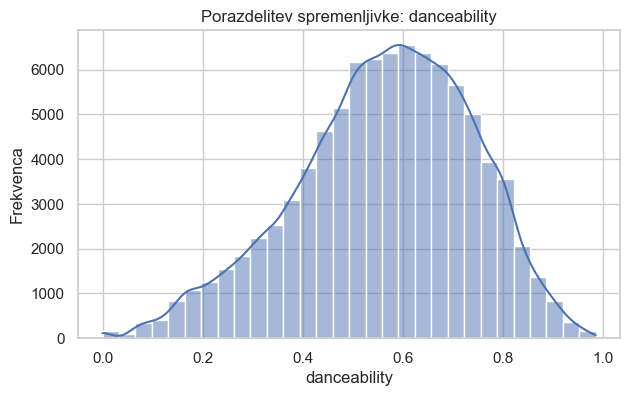

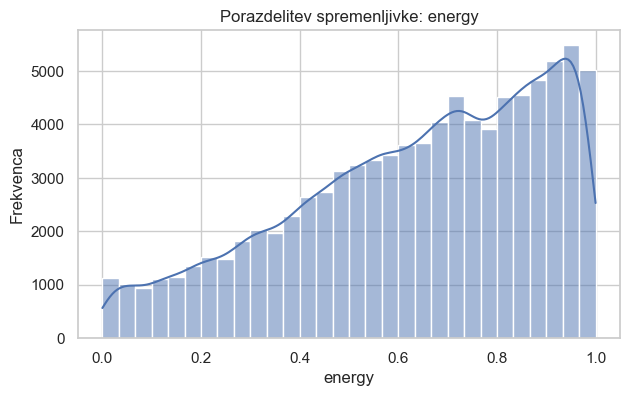

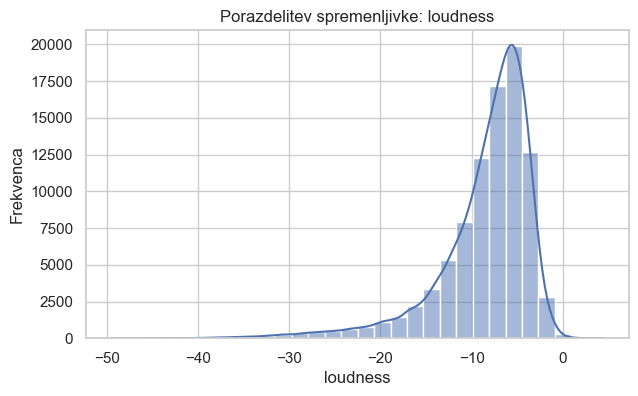

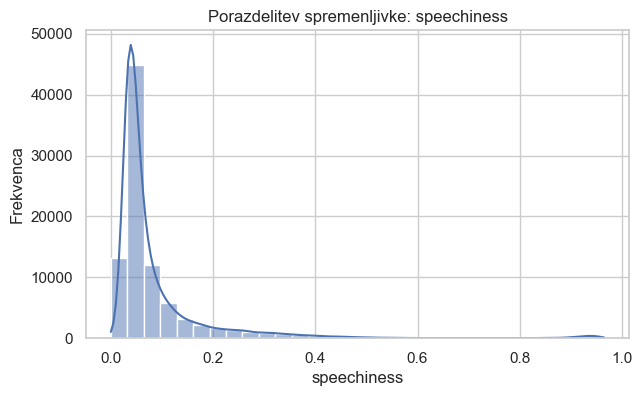

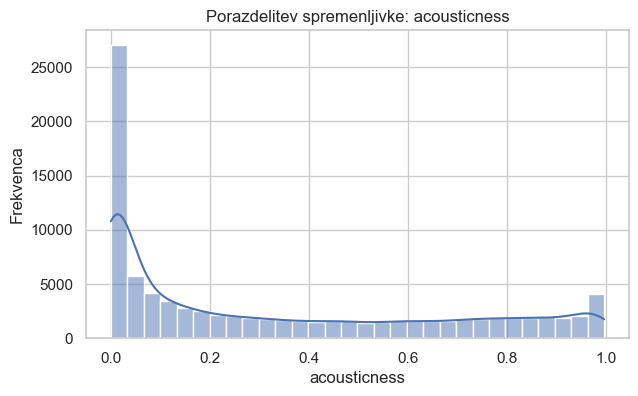

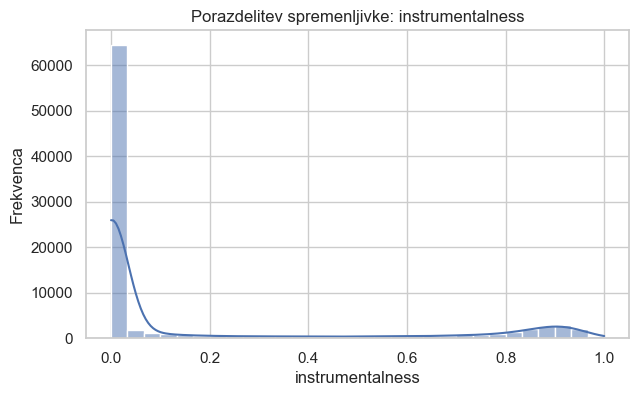

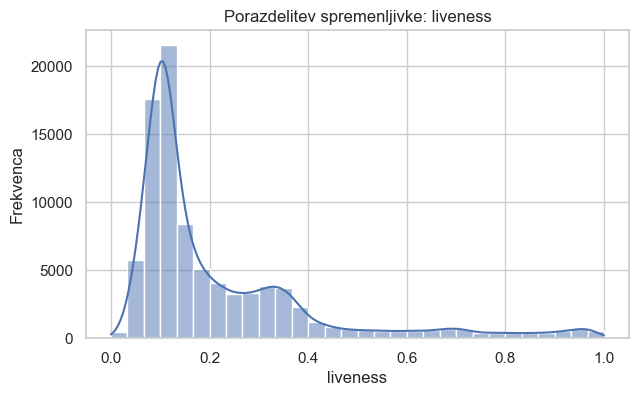

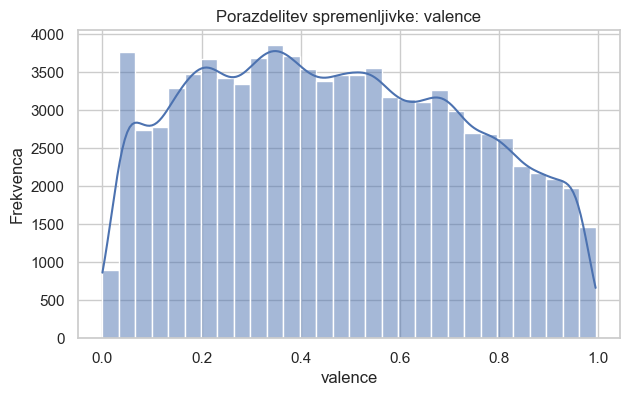

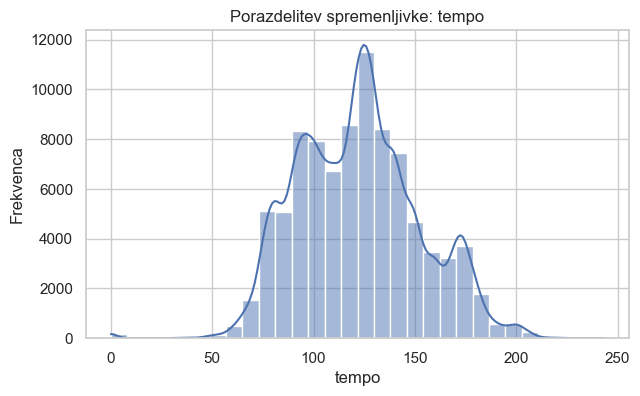

In [23]:
# Numerične spremenljivke – porazdelitve
# (Histogram + KDE → oblika porazdelitve)
for col in numeric_cols:
    plt.figure(figsize=(7, 4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Porazdelitev spremenljivke: {col}')
    plt.xlabel(col)
    plt.ylabel('Frekvenca')
    plt.show()


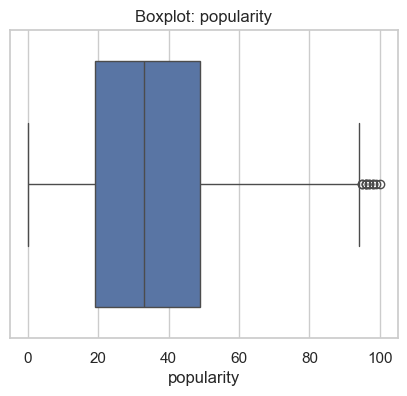

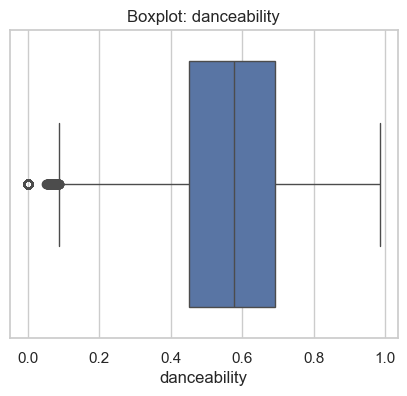

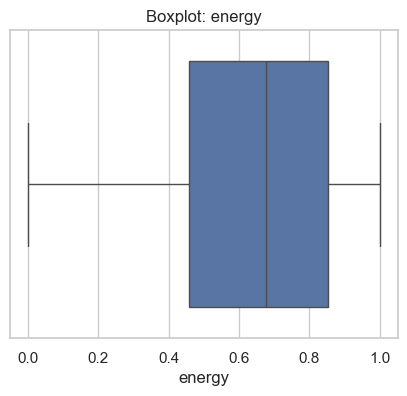

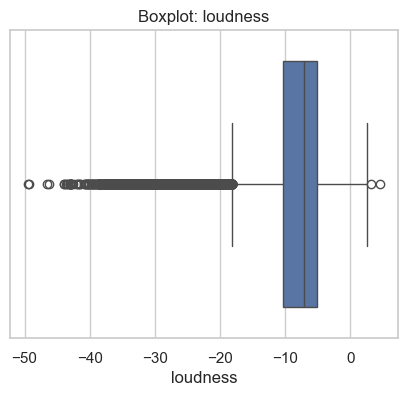

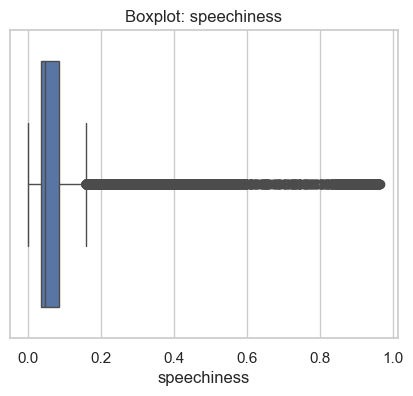

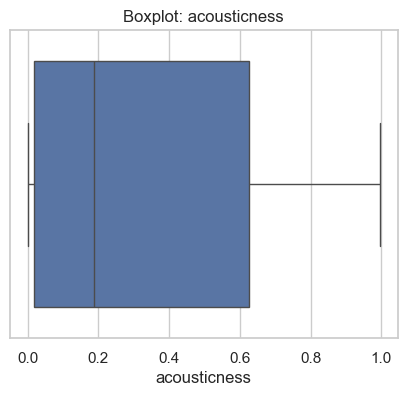

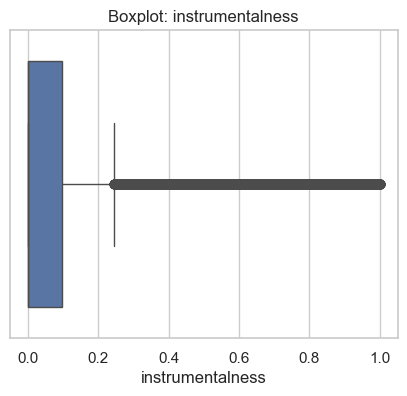

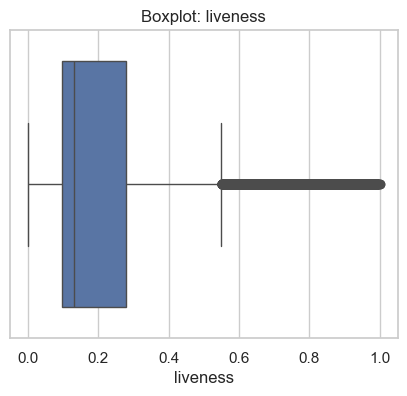

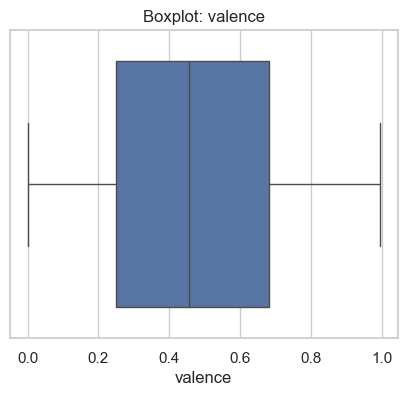

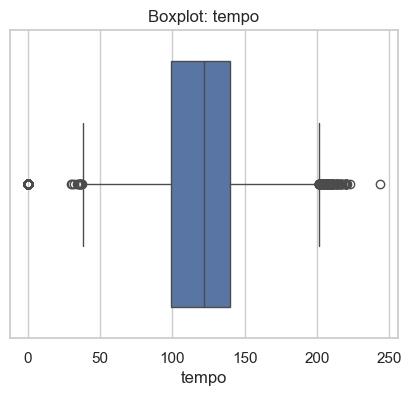

In [35]:
# Boxploti – odstopanja in outlierji
for col in numeric_cols:
    plt.figure(figsize=(5, 4))
    sns.boxplot(data=df[col], orient='h')
    plt.title(f'Boxplot: {col}')
    plt.show()


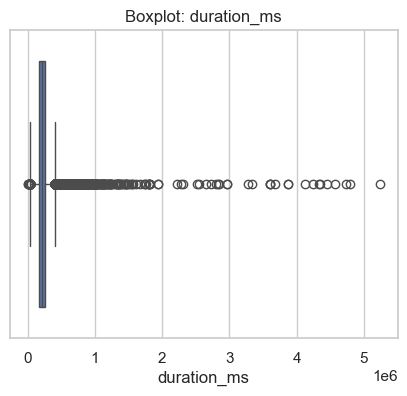

In [37]:
plt.figure(figsize=(5, 4))
sns.boxplot(data=df[duration], orient='h')
plt.title(f'Boxplot: {duration}')
plt.show()

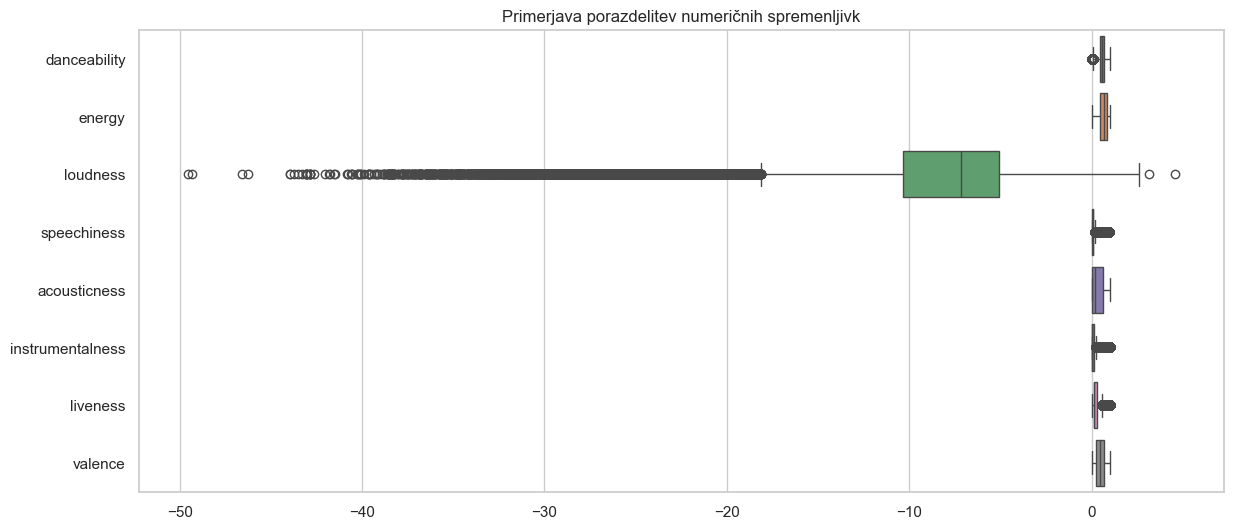

In [29]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df[audio_features], orient='h')
plt.title('Primerjava porazdelitev numeričnih spremenljivk')
plt.show()

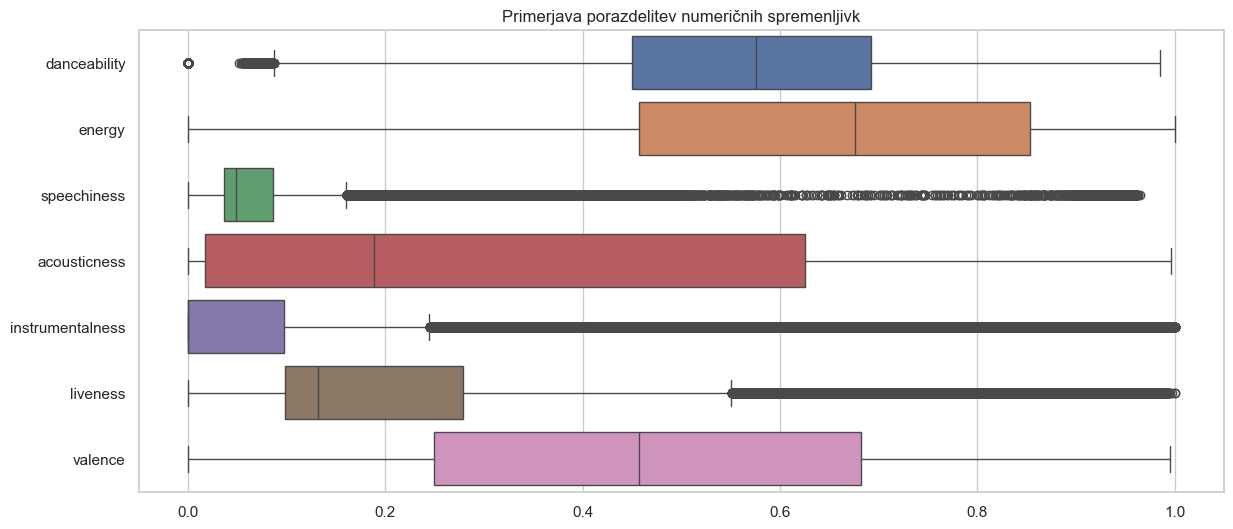

In [33]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df[audio_features].drop(columns=['loudness']), orient='h')
plt.title('Primerjava porazdelitev numeričnih spremenljivk')
plt.show()

popularity: 11 outliers (0.01%)
       popularity
20000          96
20001         100
20008          98
51664          99
67356          98
----------------------------------------
duration_ms: 4226 outliers (4.71%)
     duration_ms
253       447306
650       406103
752       445533
851       578064
896       403911
----------------------------------------
danceability: 474 outliers (0.53%)
      danceability
4077        0.0650
4090        0.0819
4097        0.0713
4131        0.0000
4183        0.0783
----------------------------------------
energy: 0 outliers (0.00%)
----------------------------------------
loudness: 5026 outliers (5.60%)
     loudness
3     -18.515
116   -28.276
117   -19.836
183   -18.827
270   -23.665
----------------------------------------
speechiness: 10644 outliers (11.86%)
     speechiness
370        0.236
692        0.204
713        0.197
768        0.403
815        0.189
----------------------------------------
acousticness: 0 outliers (0.00%)
-------------

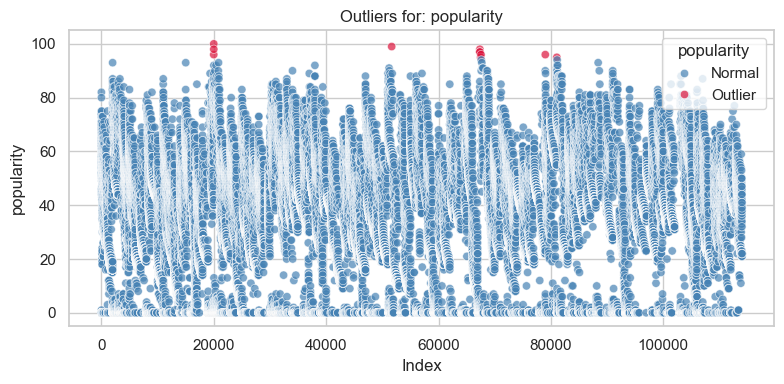

Examples of outliers in `popularity` (11):


track_id                  artists  \
20000  5IgjP7X4th6nMNDh4akUHb              Chris Brown   
20001  3nqQXoyQOWXiESFLlDF1hG     Sam Smith;Kim Petras   
20008  4uUG5RXrOk84mYEfFvj3cK  David Guetta;Bebe Rexha   
51664  2tTmW7RDtMQtBk7m2rYeSw         Bizarrap;Quevedo   
67356  5ww2BF9slyYgNOk37BlC4u            Manuel Turizo   

                                  album_name  \
20000                      Indigo (Extended)   
20001              Unholy (feat. Kim Petras)   
20008                        I'm Good (Blue)   
51664  Quevedo: Bzrp Music Sessions, Vol. 52   
67356                             La Bachata   

                                  track_name  popularity  duration_ms  \
20000                    Under The Influence          96       184613   
20001              Unholy (feat. Kim Petras)         100       156943   
20008                        I'm Good (Blue)          98       175238   
51664  Quevedo: Bzrp Music Sessions, Vol. 52          99       198937   
67356                             La Bachata          98       162637   

       explicit  danceability  energy  key  ...  mode  speechiness  \
20000      True         0.733   0.690    9  ...     0       0.0427   
20001     False         0.714   0.472    2  ...     1       0.0864   
20008      True         0.561   0.965    7  ...     0       0.0343   
51664     False         0.621   0.782    2  ...     1       0.0440   
67356     False         0.835   0.679    7  ...     0       0.0364   

       acousticness  instrumentalness  liveness  valence    tempo  \
20000       0.06350          0.000001     0.105    0.310  116.992   
20001       0.01300          0.000005     0.266    0.238  131.121   
20008       0.00383          0.000007     0.371    0.304  128.040   
51664       0.01250          0.033000     0.230    0.550  128.033   
67356       0.58300          0.000002     0.218    0.850  124.980   

       time_signature  track_genre is_any_outlier  
20000               4        dance           True  
20001               4        dance           True  
20008               4        dance           True  
51664               4      hip-hop           True  
67356               4        latin           True  

[5 rows x 21 columns]

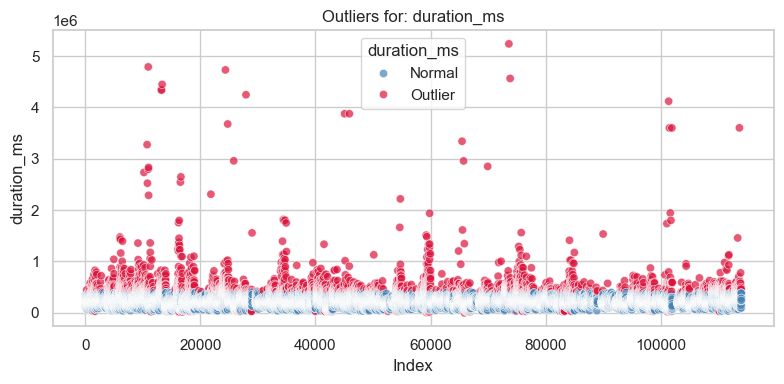

Examples of outliers in `duration_ms` (4226):


track_id         artists                     album_name  \
253  0I0l2Oo5zjpCEphpDJL0Pm   Motohiro Hata                            言ノ葉   
650  6ad7bQ48TlqAgebCExUJVe     Ichiko Aoba                              0   
752  1TRIYxcVJYPki5AX2hZzZT  Luther Allison             Bad News Is Coming   
851  5fomS2mZjvxxJ2iVH3fosc    John Elliott  All Too Well (Jake's Version)   
896  0xOIqJadsikka2so1zhghO      Harley Poe                      Horrorful   

                               track_name  popularity  duration_ms  explicit  \
253                      Rain - Long Ver.          44       447306     False   
650                             いきのこり●ぼくら          52       406103     False   
752                    Bad News Is Coming          52       445533     False   
851         All Too Well - Jake's Version          33       578064     False   
896  Alone in the Dark Mansion of Madness          26       403911      True   

     danceability  energy  key  ...  mode  speechiness  acousticness  \
253         0.588  0.6040    9  ...     1       0.0240        0.3430   
650         0.592  0.0833    0  ...     0       0.0835        0.9460   
752         0.639  0.4960    1  ...     0       0.0375        0.7130   
851         0.685  0.4830    7  ...     1       0.0253        0.0772   
896         0.335  0.6960    9  ...     0       0.0307        0.6420   

     instrumentalness  liveness  valence    tempo  time_signature  \
253          0.000069    0.2520    0.351   92.020               4   
650          0.079100    0.0941    0.205  143.243               4   
752          0.254000    0.0545    0.467  140.394               3   
851          0.000061    0.1130    0.331   93.032               4   
896          0.000000    0.1200    0.403   95.240               4   

     track_genre is_any_outlier  
253     acoustic           True  
650     acoustic           True  
752     acoustic           True  
851     acoustic           True  
896     acoustic           True  

[5 rows x 21 columns]

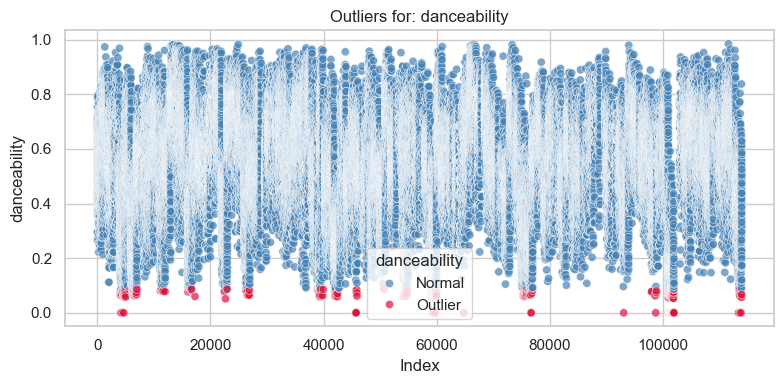

Examples of outliers in `danceability` (474):


track_id  \
4077  56oReVXIfUO9xkX7pHmEU0   
4090  4r4kqIofeGj6lms3R5m8Y0   
4097  1PeeZjiGNzzUUc8epzLtvv   
4131  59gg6zQhSKGVnkT3hWAY3l   
4183  2UZZtkoLOg7IHxeTAdPFvd   

                                                artists  \
4077  Max Richter;Louisa Fuller;Natalia Bonner;John ...   
4090                      Dmitri Shostakovich;Ares Trio   
4097                     Philip Glass;Víkingur Ólafsson   
4131                              Max Richter;Lang Lang   
4183                                      Marconi Union   

                                             album_name  \
4077                      The Blue Notebooks (15 Years)   
4090  Babadjanian: Piano Trio - Shostakovich: Piano ...   
4097                                  Classical Running   
4131                    Voyager - Essential Max Richter   
4183           Weightless (Ambient Transmission Vol. 2)   

                                   track_name  popularity  duration_ms  \
4077                On the Nature of Daylight          65       371746   
4090  Piano Trio No. 2 in E Minor: III. Largo           1       378378   
4097                      Glassworks: Opening           0       464453   
4131                            The Departure          64       151506   
4183                        Weightless Part 1          67       486840   

      explicit  danceability   energy  key  ...  mode  speechiness  \
4077     False        0.0650  0.34100   10  ...     0       0.0482   
4090     False        0.0819  0.01320    0  ...     1       0.0494   
4097     False        0.0713  0.00696    3  ...     1       0.0405   
4131     False        0.0000  0.03620    0  ...     0       0.0000   
4183     False        0.0783  0.20600    2  ...     0       0.0337   

      acousticness  instrumentalness  liveness  valence    tempo  \
4077         0.154             0.854    0.1090   0.0334   65.380   
4090         0.964             0.647    0.1200   0.0320   82.637   
4097         0.994             0.915    0.0710   0.0977  213.848   
4131         0.994             0.940    0.0958   0.0000    0.000   
4183         0.864             0.838    0.1790   0.0807   80.341   

      time_signature  track_genre is_any_outlier  
4077               4      ambient           True  
4090               4      ambient           True  
4097               3      ambient           True  
4131               0      ambient           True  
4183               5      ambient           True  

[5 rows x 21 columns]

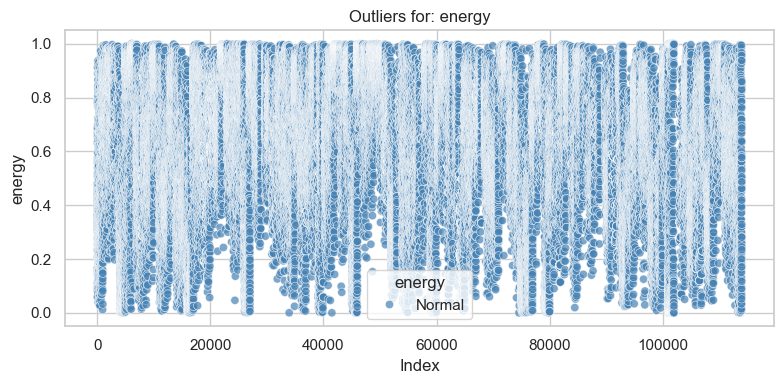

No outliers detected for `energy`.


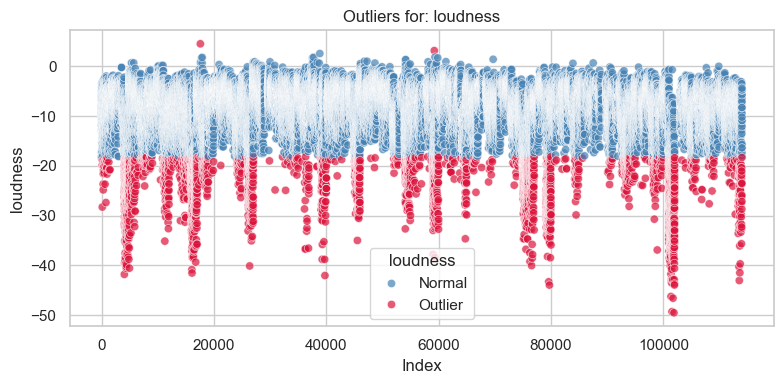

Examples of outliers in `loudness` (5026):


track_id               artists  \
3    6lfxq3CG4xtTiEg7opyCyx          Kina Grannis   
116  08OjvLnGR3M0HUhcePeMNO  Andrew Foy;Renee Foy   
117  65VhbQdqvozUntjnlFkFbZ          Kina Grannis   
183  2f4jlGvGi3ZDGogXys5FUp      Rachael Yamagata   
270  1FF6TogE9ELY71XnLPoEv6  Andrew Foy;Renee Foy   

                                            album_name  \
3    Crazy Rich Asians (Original Motion Picture Sou...   
116                   death bed (coffee for your head)   
117                                You Are My Sunshine   
183  Something In the Rain (Music from the Original...   
270                                 Just The Two Of Us   

                                            track_name  popularity  \
3                           Can't Help Falling In Love          71   
116                   death bed (coffee for your head)          47   
117                                You Are My Sunshine          60   
183  La La La (Something In the Rain, Pt. 2) [Music...          44   
270                                 Just The Two Of Us          41   

     duration_ms  explicit  danceability  energy  key  ...  mode  speechiness  \
3         201933     False         0.266  0.0596    0  ...     1       0.0363   
116       112008     False         0.565  0.0392    1  ...     1       0.0450   
117       123609     False         0.664  0.0755   10  ...     1       0.0389   
183       219613     False         0.420  0.2000    7  ...     1       0.0492   
270       196304     False         0.618  0.0830    4  ...     1       0.0570   

     acousticness  instrumentalness  liveness  valence    tempo  \
3           0.905          0.000071    0.1320    0.143  181.740   
116         0.835          0.183000    0.1170    0.601  125.399   
117         0.910          0.000000    0.1640    0.575   80.004   
183         0.929          0.490000    0.0758    0.164   87.248   
270         0.745          0.000123    0.1460    0.597   90.865   

     time_signature  track_genre is_any_outlier  
3                 3     acoustic           True  
116               4     acoustic           True  
117               1     acoustic           True  
183               4     acoustic           True  
270               4     acoustic           True  

[5 rows x 21 columns]

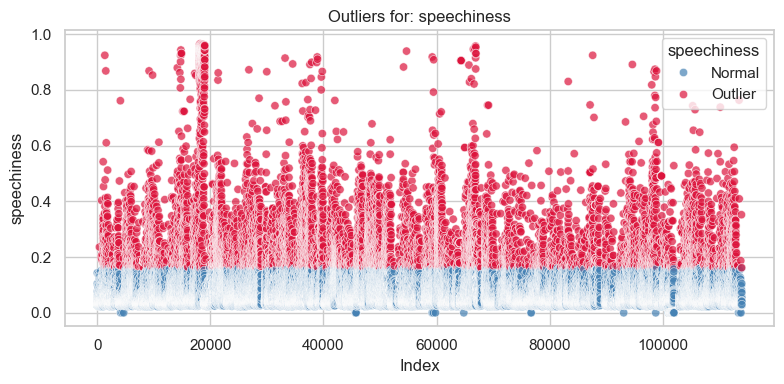

Examples of outliers in `speechiness` (10644):


track_id                        artists  \
370  1wSZdWFZphxDh6iJhWlIUi                   Ben Woodward   
692  5CU7ewecONNlWAJHu04HJQ        The Bridge City Sinners   
713  1z2fSrYZqrO5tMqzULn9OD                   Tyrone Wells   
768  1m3Lsbhkn6yL8apzsCiukd                   Ben Woodward   
815  10a6GUpyRLdfadUPRL5wBg  Postcards & Polaroids;Sad Boy   

                album_name             track_name  popularity  duration_ms  \
370  Don't Wanna Leave You  Don't Wanna Leave You          38       211672   
692    Bridge City Sinners             Come on In          28       204926   
713  The "Hits" | Acoustic   Days I Will Remember          30       201506   
768    Memories (Acoustic)    Memories (Acoustic)          46       183337   
815              Covers EP    Supermarket Flowers          45       145753   

     explicit  danceability  energy  key  ...  mode  speechiness  \
370     False         0.672   0.644   11  ...     1        0.236   
692     False         0.544   0.911    9  ...     1        0.204   
713     False         0.804   0.457    6  ...     1        0.197   
768     False         0.802   0.183    8  ...     1        0.403   
815     False         0.463   0.156    6  ...     1        0.189   

     acousticness  instrumentalness  liveness  valence    tempo  \
370         0.795               0.0     0.146    0.549  148.135   
692         0.661               0.0     0.344    0.851  114.776   
713         0.600               0.0     0.150    0.552   98.035   
768         0.809               0.0     0.109    0.664   91.078   
815         0.890               0.0     0.115    0.478  180.191   

     time_signature  track_genre is_any_outlier  
370               4     acoustic           True  
692               4     acoustic           True  
713               4     acoustic           True  
768               4     acoustic           True  
815               4     acoustic           True  

[5 rows x 21 columns]

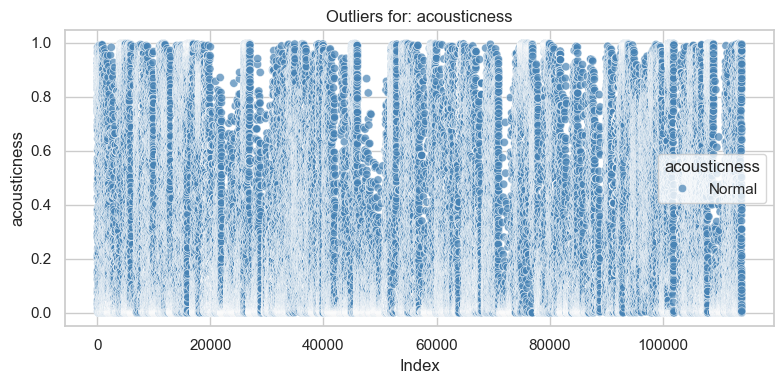

No outliers detected for `acousticness`.


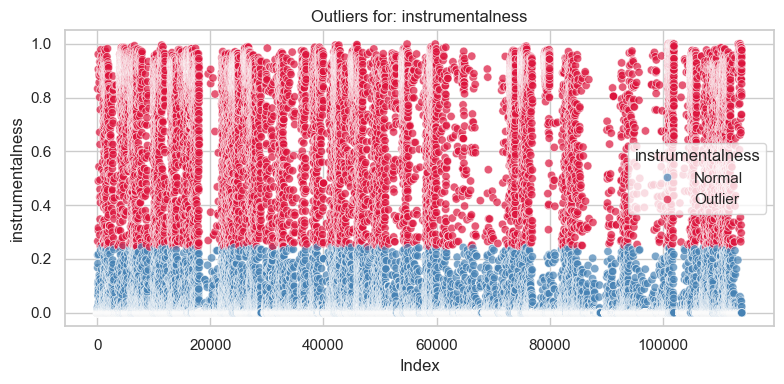

Examples of outliers in `instrumentalness` (19613):


track_id                             artists  \
62   7x4b0UccXSKBWxWmjcrG2T                         Kurt Cobain   
77   4qCbMMMuEB56kHd4zPE6GD  Eddie Vedder;Nusrat Fateh Ali Khan   
163  5RO0MNa5hBKIM4OcjygadU                    Joseph Sullinger   
173  7Ca2CkwSqHyr3eCh8IRdjz            Agustín Amigó;Nylonwings   
183  2f4jlGvGi3ZDGogXys5FUp                    Rachael Yamagata   

                                            album_name  \
62                Montage Of Heck: The Home Recordings   
77                                     Eat, Pray, Love   
163                                            Chi Mai   
173                                  Mujer con Abanico   
183  Something In the Rain (Music from the Original...   

                                            track_name  popularity  \
62                                      And I Love Her          66   
77                                       The Long Road          45   
163                                            Chi Mai          40   
173                                  Mujer con Abanico          41   
183  La La La (Something In the Rain, Pt. 2) [Music...          44   

     duration_ms  explicit  danceability  energy  key  ...  mode  speechiness  \
62        124933     False         0.616   0.282    1  ...     1       0.0331   
77        330933     False         0.537   0.342    2  ...     1       0.0273   
163       188695     False         0.739   0.287    6  ...     0       0.0590   
173       156787     False         0.769   0.135    5  ...     0       0.0610   
183       219613     False         0.420   0.200    7  ...     1       0.0492   

     acousticness  instrumentalness  liveness  valence    tempo  \
62          0.983             0.833    0.1300    0.435   96.638   
77          0.645             0.266    0.0687    0.253  109.236   
163         0.969             0.961    0.1110    0.557   80.640   
173         0.986             0.905    0.1060    0.471  103.939   
183         0.929             0.490    0.0758    0.164   87.248   

     time_signature  track_genre is_any_outlier  
62                4     acoustic           True  
77                4     acoustic           True  
163               4     acoustic           True  
173               4     acoustic           True  
183               4     acoustic           True  

[5 rows x 21 columns]

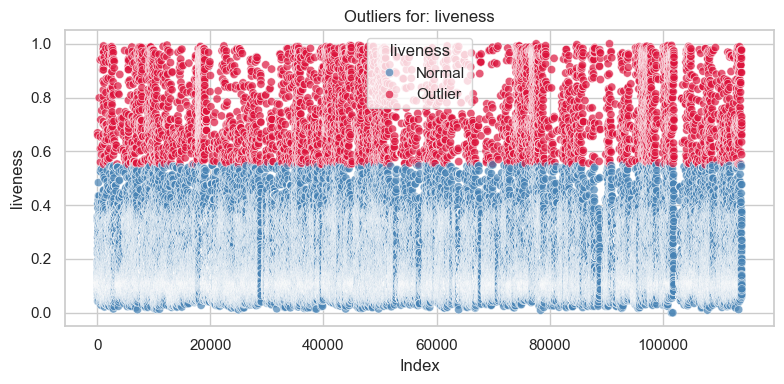

Examples of outliers in `liveness` (6981):


track_id                  artists              album_name  \
51   3ILmwMefYZoQh5Cf5jeuUQ            Motohiro Hata             Documentary   
73   2E9viCx0hJKNKNThd2MdGQ              Bailey Jehl    You're Still The One   
343  37jsciEAFxwyjXx0kV6aO6         Rail Yard Ghosts  Songs from the Lowdown   
518  6Fomnvc3pkLvUQYUkhiQPx              Canyon City          Midnight Waves   
535  5bC6ONDsL88snGN6QasjZH  Sonny Boy Williamson II    More Real Folk Blues   

               track_name  popularity  duration_ms  explicit  danceability  \
51                透明だった世界          61       232360     False         0.373   
73   You're Still The One          56       177500     False         0.607   
343      A Month from Now          34       192392     False         0.415   
518                 Waves          45       262954     False         0.407   
535               Help Me          60       188200     False         0.745   

     energy  key  ...  mode  speechiness  acousticness  instrumentalness  \
51    0.914    0  ...     1       0.0565         0.076          0.000000   
73    0.473    2  ...     1       0.0340         0.712          0.000000   
343   0.619    2  ...     0       0.1230         0.946          0.000028   
518   0.357    1  ...     1       0.0436         0.775          0.001050   
535   0.436    5  ...     0       0.0430         0.597          0.021300   

     liveness  valence    tempo  time_signature  track_genre is_any_outlier  
51      0.669    0.560  168.210               4     acoustic           True  
73      0.660    0.540  119.698               4     acoustic           True  
343     0.799    0.739   77.009               4     acoustic           True  
518     0.940    0.253  112.207               4     acoustic           True  
535     0.610    0.771  114.216               4     acoustic           True  

[5 rows x 21 columns]

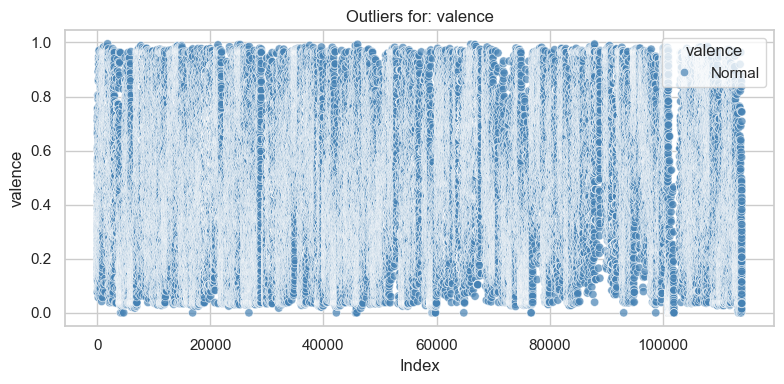

No outliers detected for `valence`.


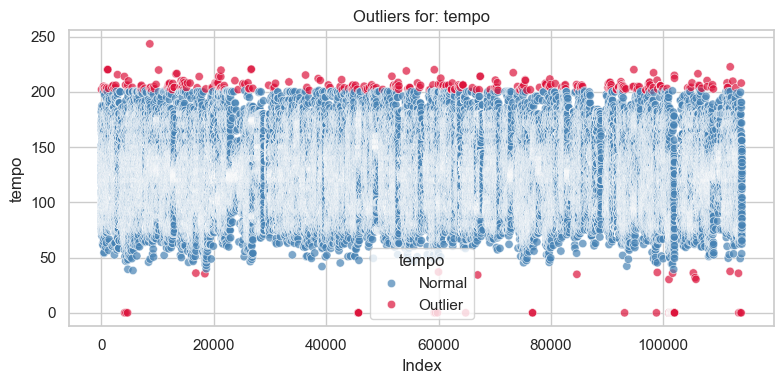

Examples of outliers in `tempo` (514):


track_id                    artists  \
32   1m5LC29RE52Bxy7hxvpOlL           Chord Overstreet   
384  63wsZUhUZLlh1OsyrZq7sz  Boyce Avenue;Kina Grannis   
519  6cMzeng5QA8fd2qqiMeIyg                Jonah Baker   
561  2dMkrhsWFVP2rHZmTEKkeh                Mat Kearney   
655  7quFUf8mR7wUxeJip0awxn                  Howie Day   

                                            album_name  \
32                        Christmas Country Songs 2022   
384                             Cover Sessions, Vol. 2   
519  Running Up That Hill (A Deal With God) [Acoustic]   
561                                          CRAZYTALK   
655                                    Sound The Alarm   

                                            track_name  popularity  \
32         All I Want For Christmas Is A Real Good Tan           0   
384                                           Fast Car          61   
519  Running Up That Hill (A Deal With God) - Acoustic          51   
561                                         Wanted Man          59   
655                                      Longest Night          43   

     duration_ms  explicit  danceability  energy  key  ...  mode  speechiness  \
32        234186     False         0.593   0.455    6  ...     1       0.0388   
384       304293     False         0.392   0.251   10  ...     1       0.0363   
519       168042     False         0.385   0.134    5  ...     0       0.0476   
561       235106     False         0.514   0.319    3  ...     1       0.0941   
655       215746     False         0.231   0.636   11  ...     1       0.0339   

     acousticness  instrumentalness  liveness  valence    tempo  \
32        0.36600               0.0    0.0914    0.564  202.019   
384       0.80700               0.0    0.0797    0.508  204.961   
519       0.89900               0.0    0.1130    0.427  203.816   
561       0.80500               0.0    0.2110    0.677  203.651   
655       0.00402               0.0    0.0504    0.244  202.098   

     time_signature  track_genre is_any_outlier  
32                4     acoustic           True  
384               4     acoustic           True  
519               4     acoustic           True  
561               4     acoustic           True  
655               3     acoustic           True  

[5 rows x 21 columns]

In [10]:
sns.set(style='whitegrid')

is_outlier = pd.DataFrame(False, index=df.index, columns=numeric_cols)
outliers = {}

for col in numeric_cols:
    # coerce to numeric (non-numeric -> NaN), work on the numeric series
    num = pd.to_numeric(df[col], errors='coerce')
    if num.dropna().empty:
        print(f"Skipped `{col}`: no numeric data.")
        continue

    Q1 = num.quantile(0.25)
    Q3 = num.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    mask = (num < lower) | (num > upper)
    mask = mask.fillna(False)  # treat NaNs as non-outlier here

    is_outlier[col] = mask
    outliers[col] = df.loc[mask]

    print(f"{col}: {mask.sum()} outliers ({mask.mean() * 100:.2f}%)")
    if mask.sum():
        print(df.loc[mask, [col]].head())
    print('-' * 40)

# optional flag: any-column outlier
df['is_any_outlier'] = is_outlier.any(axis=1)

# plot each numeric column, highlighting only its own outliers
for col in numeric_cols:
    mask = is_outlier[col]
    status = mask.map({False: 'Normal', True: 'Outlier'})

    plt.figure(figsize=(8, 4))
    sns.scatterplot(
        x=df.index, y=df[col],
        hue=status,
        palette={'Normal': 'steelblue', 'Outlier': 'crimson'},
        alpha=0.7, legend='brief'
    )
    plt.title(f'Outliers for: {col}')
    plt.xlabel('Index')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

    n_out = mask.sum()
    if n_out:
        print(f"Examples of outliers in `{col}` ({n_out}):")
        display(df.loc[mask].head())  # Jupyter-friendly
    else:
        print(f"No outliers detected for `{col}`.")
    print('=' * 60)

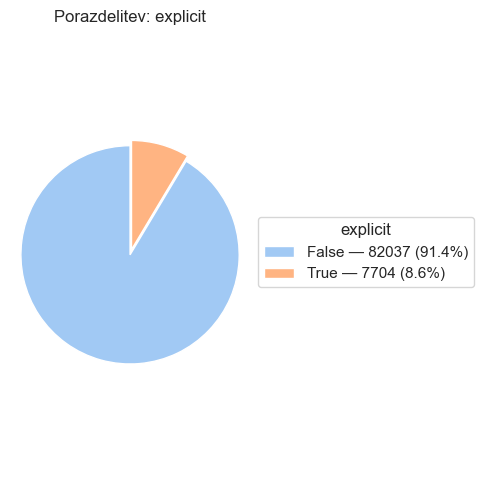


explicit counts:
explicit
False    82037
True      7704
Name: count, dtype: int64

Percentages (%)
explicit
False    91.42
True      8.58
Name: count, dtype: float64
----------------------------------------


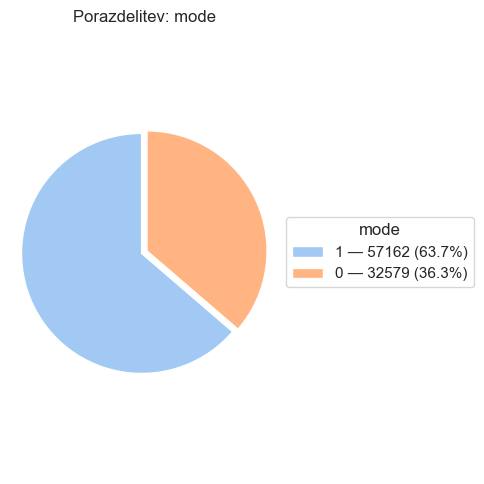


mode counts:
mode
1    57162
0    32579
Name: count, dtype: int64

Percentages (%)
mode
1    63.7
0    36.3
Name: count, dtype: float64
----------------------------------------


In [11]:
sns.set(style='whitegrid')

for col in binary_cols:
    if col not in df.columns:
        print(f"Skipped: column `{col}` not found.")
        continue

    # treat missing as its own category
    ser = df[col].fillna('Missing')
    counts = ser.value_counts()
    if counts.empty:
        print(f"Skipped: `{col}` has no data after filling missing.")
        continue

    total = counts.sum()
    labels = counts.index.astype(str).tolist()
    sizes = counts.values

    # readable legend labels: "label — count (pct%)"
    legend_labels = [
        f"{lab} — {cnt} ({cnt / total * 100:.1f}%)"
        for lab, cnt in zip(labels, sizes)
    ]

    colors = sns.color_palette('pastel', n_colors=len(sizes))
    explode = [0.05 if i == sizes.argmax() else 0 for i in range(len(sizes))]

    fig, ax = plt.subplots(figsize=(5, 5))
    wedges, _ = ax.pie(
        sizes,
        labels=None,
        colors=colors,
        startangle=90,
        explode=explode,
        wedgeprops={'edgecolor': 'white'}
    )
    ax.set_title(f'Porazdelitev: {col}')
    ax.axis('equal')  # keep pie circular

    # place a compact legend to the right for readability
    ax.legend(wedges, legend_labels, title=col, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()

    # print counts and percentages below the plot
    print(f"\n{col} counts:")
    print(counts)
    print("\nPercentages (%)")
    print((counts / total * 100).round(2))
    print("-" * 40)

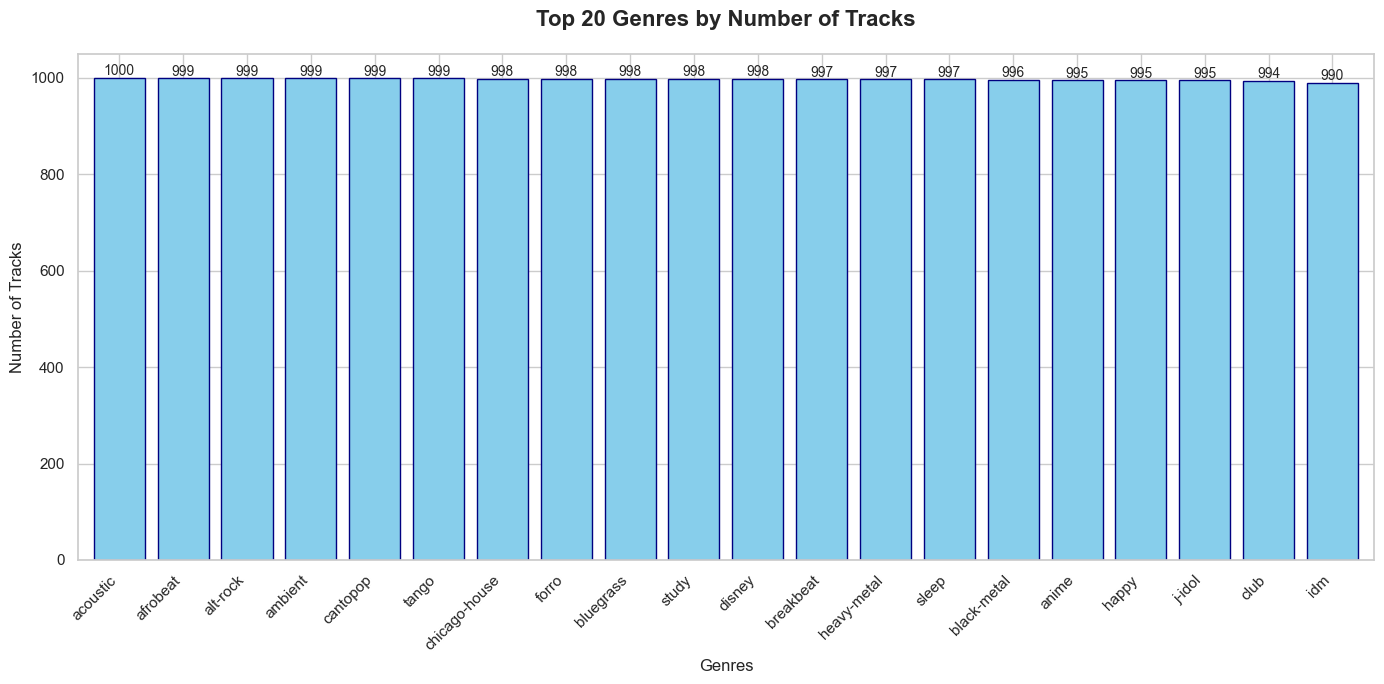

Total unique genres: 113


In [12]:
# Kategorične spremenljivke (smiselni barploti)

# Top 20 Genres by Number of Tracks
top_genres = df['track_genre'].value_counts().head(20)

plt.figure(figsize=(14, 7))
top_genres.plot(kind='bar', color='skyblue', edgecolor='navy', width=0.8)
plt.title('Top 20 Genres by Number of Tracks', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Genres')
plt.ylabel('Number of Tracks')
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(top_genres):
    plt.text(i, v + 5, str(v), ha='center', fontsize=10)
plt.tight_layout()
plt.show()
print(f"Total unique genres: {df['track_genre'].nunique()}")

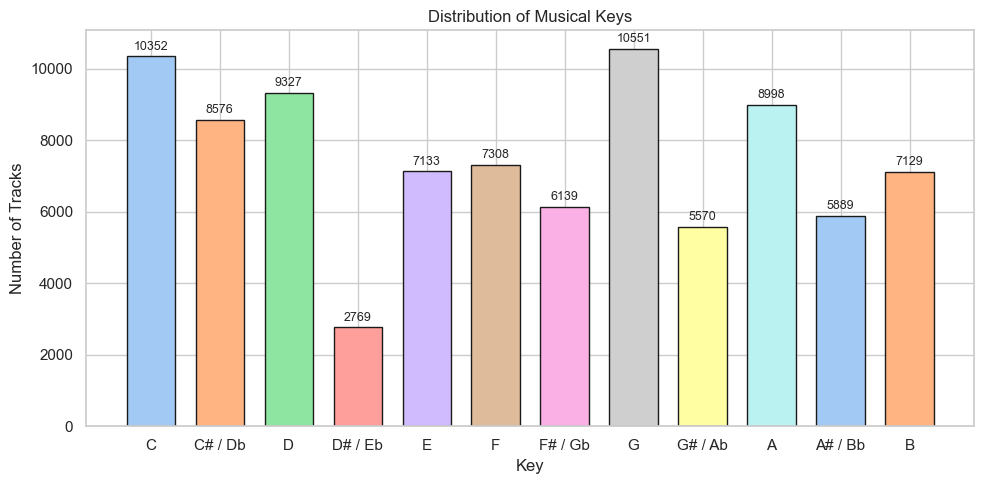

In [13]:
# mapping from Spotify-style key integers to human-readable names
KEY_MAP = {
    0: 'C', 1: 'C# / Db', 2: 'D', 3: 'D# / Eb', 4: 'E',
    5: 'F', 6: 'F# / Gb', 7: 'G', 8: 'G# / Ab', 9: 'A',
    10: 'A# / Bb', 11: 'B'
}

# prepare key labels (keep NaNs as 'Unknown')
key_labels = df['key'].map(KEY_MAP).fillna('Unknown').astype(str)

# desired order: natural musical order, put 'Unknown' last if present
base_order = [KEY_MAP[i] for i in range(12)]
order = base_order + (['Unknown'] if 'Unknown' in key_labels.values else [])

# counts reindexed to the desired order (zeros if a key absent)
counts = key_labels.value_counts().reindex(order, fill_value=0)

# optionally drop zero-count keys
# counts = counts[counts > 0]

# plot with matplotlib so labels are centered on each bar; avoid seaborn palette-without-hue warning
plt.figure(figsize=(10, 5))
positions = range(len(counts))
colors = sns.color_palette('pastel', n_colors=len(counts))
bars = plt.bar(positions, counts.values, color=colors, edgecolor='k', width=0.7)

# set ticks centered under each bar
plt.xticks(positions, counts.index, rotation=0, ha='center')
plt.xlabel('Key')
plt.ylabel('Number of Tracks')
plt.title('Distribution of Musical Keys')

# annotate counts above bars
for pos, val in zip(positions, counts.values):
    plt.text(pos, val + max(counts.values) * 0.01 + 0.5, str(int(val)), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


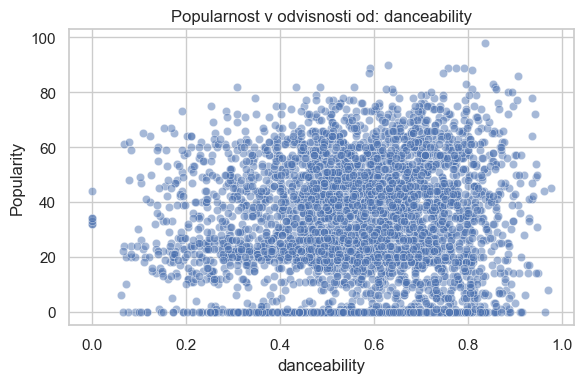

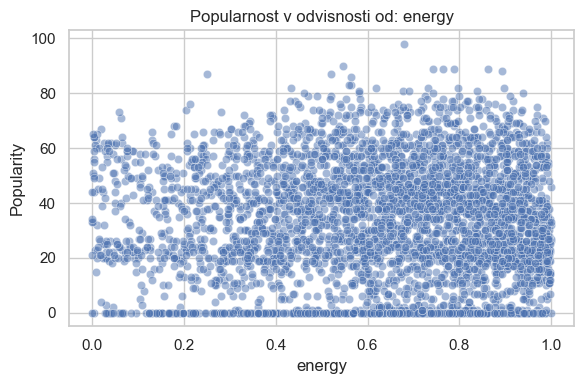

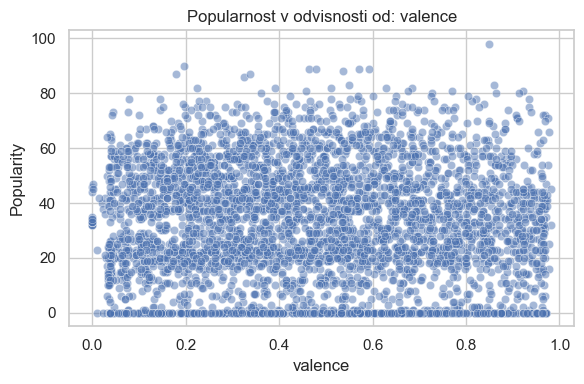

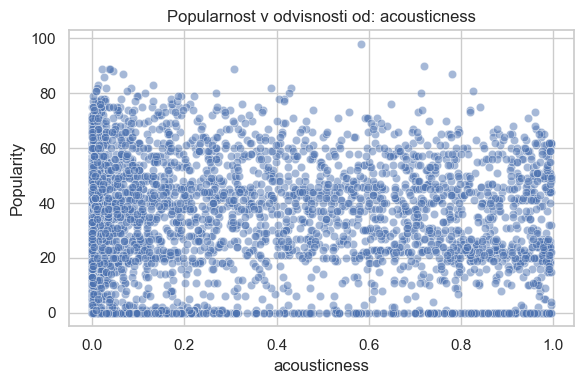

In [14]:
# Smiselne povezave med spremenljivkami
# Popularnost vs. lastnosti skladbe
features_vs_popularity = [
    'danceability', 'energy', 'valence', 'acousticness'
]
sample = df.sample(n=4000, random_state=999)

for col in features_vs_popularity:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=sample, x=col, y='popularity', alpha=0.5)
    plt.title(f'Popularnost v odvisnosti od: {col}')
    plt.xlabel(col)
    plt.ylabel('Popularity')
    plt.tight_layout()
    plt.show()


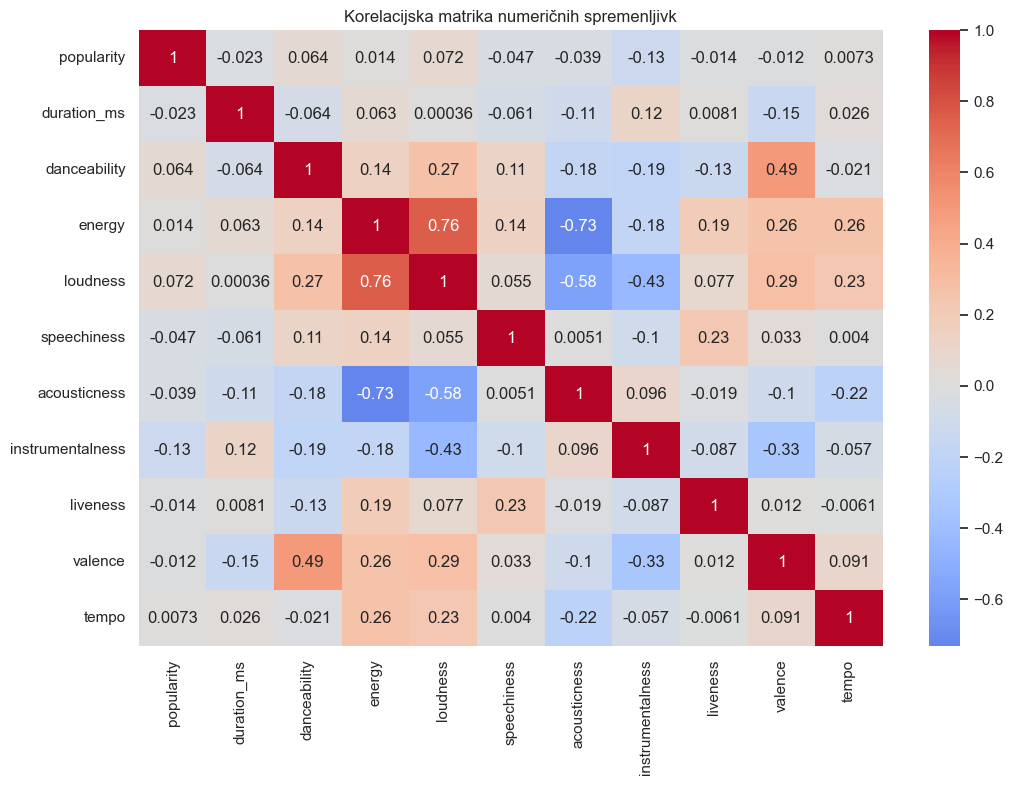

In [15]:
# Korelacijska matrika
plt.figure(figsize=(12, 8))
sns.heatmap(
    df[numeric_cols].corr(),
    annot=True,
    cmap='coolwarm',
    center=0
)
plt.title('Korelacijska matrika numeričnih spremenljivk')
plt.show()


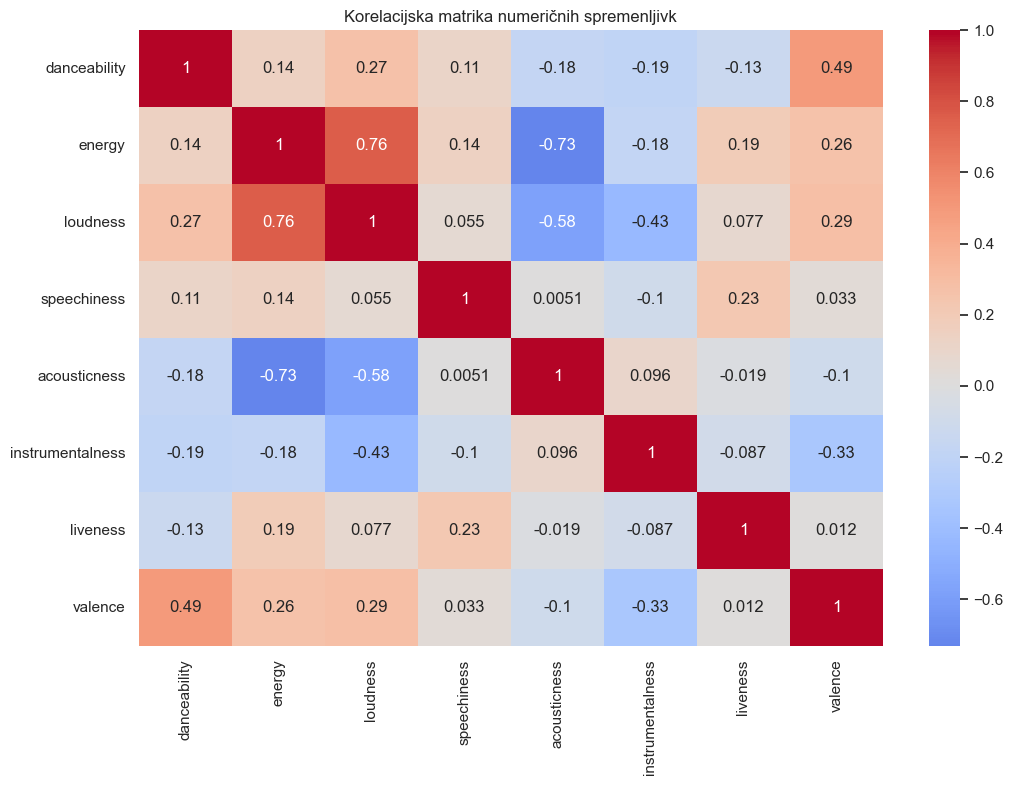

In [27]:
# Korelacijska matrika
plt.figure(figsize=(12, 8))
sns.heatmap(
    df[audio_features].corr(),
    annot=True,
    cmap='coolwarm',
    center=0
)
plt.title('Korelacijska matrika numeričnih spremenljivk')
plt.show()


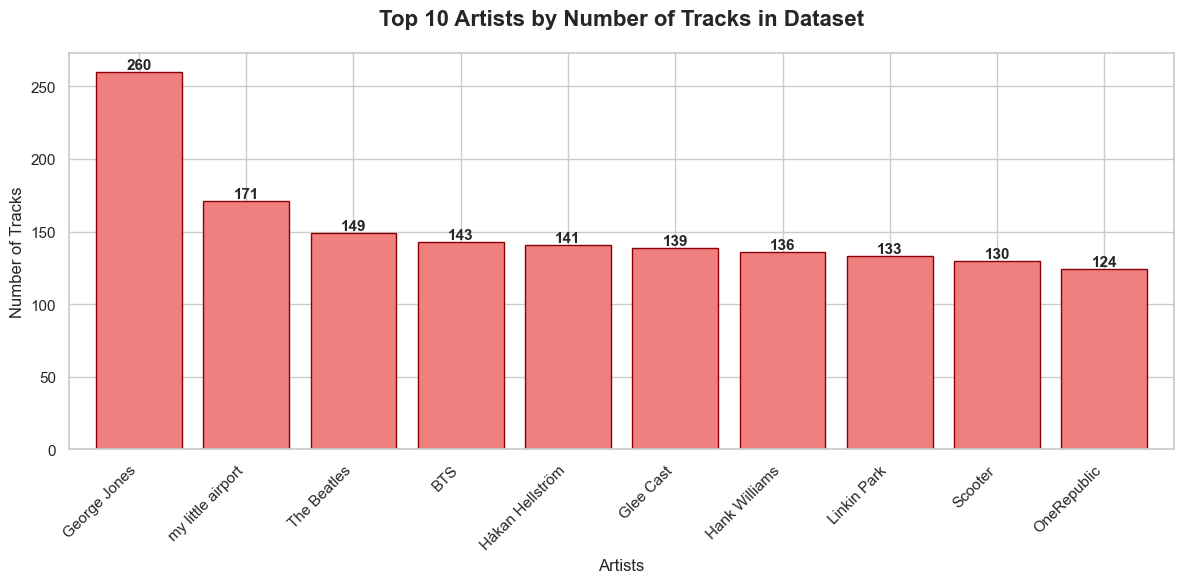

Total unique artists: 31437


In [16]:
# Tekstualni stolpci – smiselna statistika
# Top 10 Artists by Number of Tracks
top_artists = df['artists'].value_counts().head(10)

plt.figure(figsize=(12, 6))
top_artists.plot(kind='bar', color='lightcoral', edgecolor='darkred', width=0.8)
plt.title('Top 10 Artists by Number of Tracks in Dataset', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Artists')
plt.ylabel('Number of Tracks')
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(top_artists):
    plt.text(i, v + 2, str(v), ha='center', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Total unique artists: {df['artists'].nunique()}")

<Figure size 1400x1000 with 0 Axes>

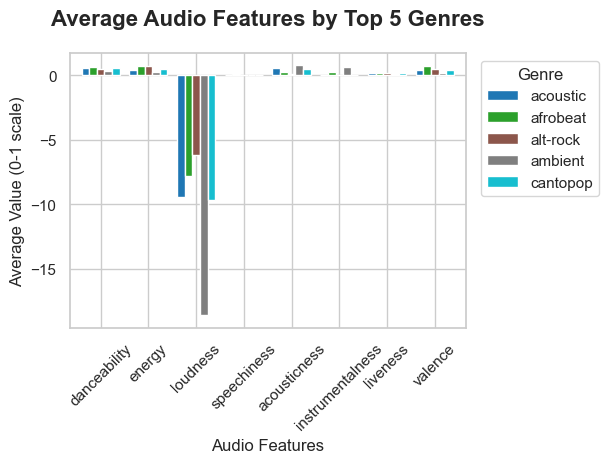

In [38]:
# Average Audio Features for Top 5 Genres
top5_genres = df['track_genre'].value_counts().head(5).index
genre_features = df[df['track_genre'].isin(top5_genres)].groupby('track_genre')[audio_features].mean()

plt.figure(figsize=(14, 10))
genre_features.T.plot(kind='bar', cmap='tab10', width=0.8)
plt.title('Average Audio Features by Top 5 Genres', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Average Value (0-1 scale)')
plt.xlabel('Audio Features')
plt.legend(title='Genre', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1400x1000 with 0 Axes>

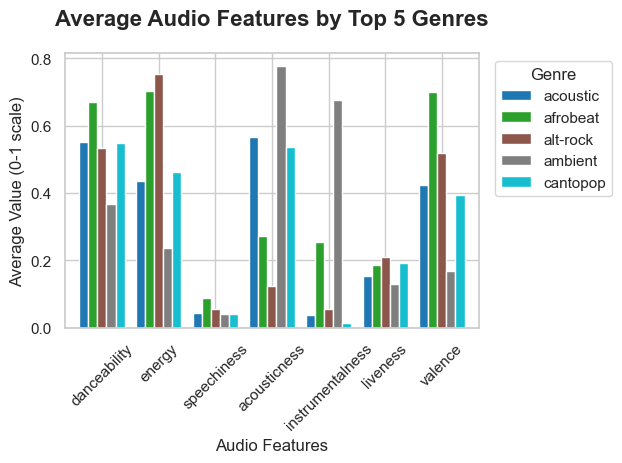

In [44]:
top5_genres = df['track_genre'].value_counts().head(5).index
features_no_loudness = [f for f in audio_features if f != 'loudness' and f in df.columns]
genre_features = (
    df[df['track_genre'].isin(top5_genres)]
    .groupby('track_genre')[features_no_loudness]
    .mean()
)
plt.figure(figsize=(14, 10))
genre_features.T.plot(kind='bar', cmap='tab10', width=0.8)
plt.title('Average Audio Features by Top 5 Genres', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Average Value (0-1 scale)')
plt.xlabel('Audio Features')
plt.legend(title='Genre', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

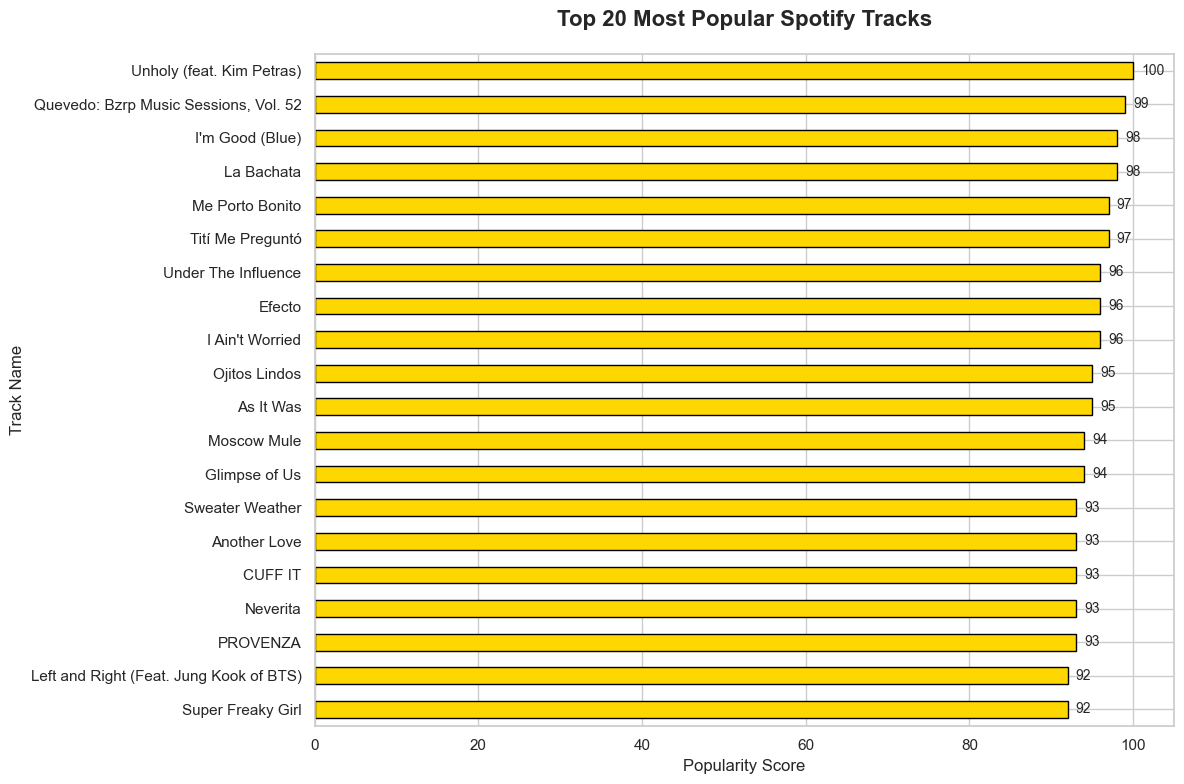

Top 20 Tracks Table:


In [20]:
# Top 20 Most Popular Tracks (Table + Bar)
top_tracks = df.nlargest(20, 'popularity')[
    ['track_name', 'artists', 'track_genre', 'popularity', 'danceability', 'energy']]

# Bar chart
plt.figure(figsize=(12, 8))
top_tracks.set_index('track_name')['popularity'].plot(kind='barh', color='gold', edgecolor='black')
plt.title('Top 20 Most Popular Spotify Tracks', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Popularity Score')
plt.ylabel('Track Name')
plt.gca().invert_yaxis()
for i, v in enumerate(top_tracks['popularity']):
    plt.text(v + 1, i, str(v), va='center', fontsize=10)
plt.tight_layout()
plt.show()

# Display table
print("Top 20 Tracks Table:")
display(top_tracks.style.background_gradient(cmap='viridis'))

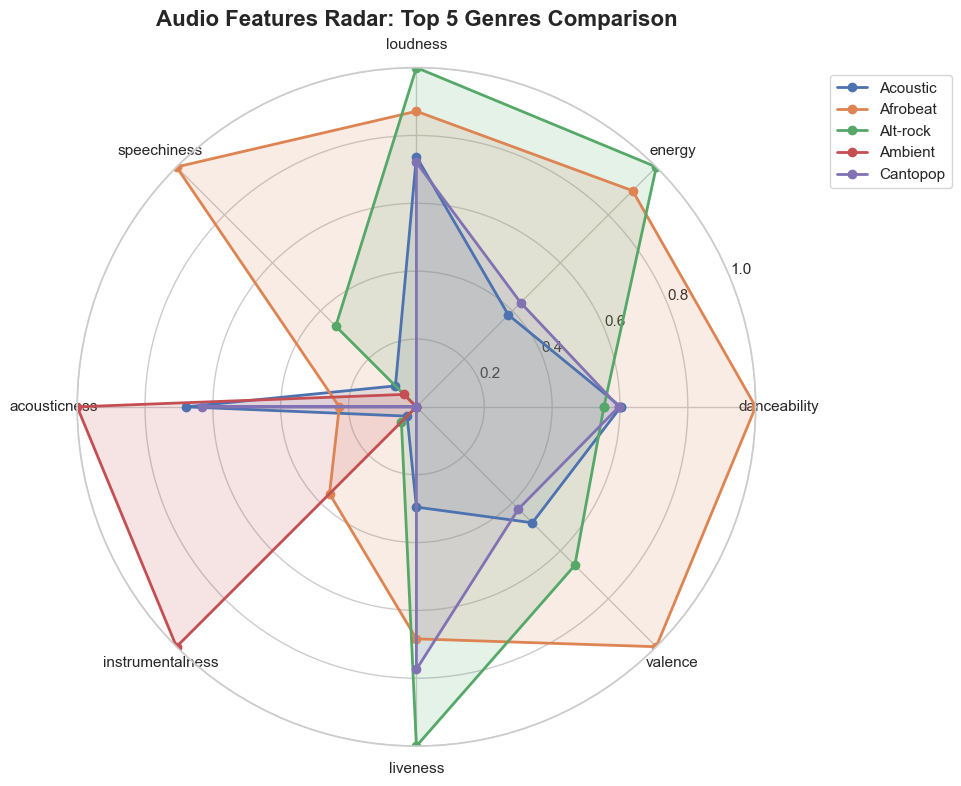

In [48]:
# Radar Chart: Compare Top 5 Genres
top5 = df['track_genre'].value_counts().head(5).index
radar_df = df.groupby('track_genre')[audio_features].mean().loc[top5]

# Normalize for radar (0-1)
radar_norm = radar_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0)

features = radar_df.columns
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
for i, genre in enumerate(radar_norm.index):
    values = radar_norm.loc[genre].tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=genre.capitalize())
    ax.fill(angles, values, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(features)
ax.set_ylim(0, 1)
ax.set_title('Audio Features Radar: Top 5 Genres Comparison', fontsize=16, fontweight='bold', pad=30)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.show()

In [ ]:
# # Izbor spremenljivk (Feature Selection)

# print("\n--- Izbor spremenljivk ---")
# # Pretvorba duration_ms v duration_min (če obstaja)
# if 'duration_ms' in df.columns:
#     df['duration_min'] = df['duration_ms'] / 60000
#     print("Ustvarjena značilka 'duration_min'.")
# else:
#     print("Stolpec 'duration_ms' ne obstaja, preskočeno ustvarjanje 'duration_min'.")
#
# # Ustvarjanje binarne značilke 'is_instrumental' (če obstaja instrumentalness)
# if 'instrumentalness' in df.columns:
#     df['is_instrumental'] = (df['instrumentalness'] > 0.5).astype(int)
#     print("Ustvarjena značilka 'is_instrumental' (1 če instrumentalness > 0.5, sicer 0).")
# else:
#     print("Stolpec 'instrumentalness' ne obstaja, preskočeno ustvarjanje 'is_instrumental'.")
#
# # Prikaz posodobljenih informacij
# print("\nPosodobljene informacije o podatkovnem okviru po čiščenju in inženirstvu značilk:")
# df.info()

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def bivariate_summary(df, target='popularity', make_binary=False,
                      binary_method='median', max_cardinality=50, alpha=0.05):
    """
    df: input DataFrame
    target: numeric target column name
    make_binary: if True create a binary target column 'target_bin' using binary_method
                 binary_method: 'median', 'mean', or a float percentile like 0.75
    max_cardinality: skip categorical features with > max_cardinality unique values
    Returns: (results_df, plots_shown) where results_df contains test, stat, p, effect_size
    """
    sns.set(style='whitegrid')
    if target not in df.columns:
        raise ValueError(f"target {target} not in DataFrame")

    df2 = df.copy()
    if make_binary:
        if binary_method == 'median':
            thresh = df2[target].median()
        elif binary_method == 'mean':
            thresh = df2[target].mean()
        elif isinstance(binary_method, float):
            thresh = df2[target].quantile(binary_method)
        else:
            raise ValueError("binary_method must be 'median', 'mean' or float percentile")
        df2[f'{target}_bin'] = (df2[target] > thresh).astype(int)
        bin_target = f'{target}_bin'
    else:
        bin_target = None

    def cohen_d(x, y):
        x, y = np.asarray(x), np.asarray(y)
        nx, ny = len(x), len(y)
        dof = nx + ny - 2
        pooled_sd = np.sqrt(((nx - 1) * x.var(ddof=1) + (ny - 1) * y.var(ddof=1)) / dof)
        return (x.mean() - y.mean()) / pooled_sd if pooled_sd > 0 else np.nan

    def eta_squared(groups, values):
        overall_mean = values.mean()
        ss_between = sum(len(g) * (g.mean() - overall_mean) ** 2 for g in groups)
        ss_total = ((values - overall_mean) ** 2).sum()
        return ss_between / ss_total if ss_total > 0 else np.nan

    results = []
    plots_dir = "bivar_plots"
    os.makedirs(plots_dir, exist_ok=True)

    # Define candidate features (exclude target and obvious ids)
    exclude = {target}
    if bin_target:
        exclude.add(bin_target)
    exclude.update({'track_id'})  # skip raw id
    features = [c for c in df2.columns if c not in exclude]

    for feat in features:
        col = df2[feat]
        n_unique = col.dropna().nunique()
        # Skip very high-cardinality text columns (e.g. track_name)
        if col.dtype == object and n_unique > max_cardinality:
            results.append({'feature': feat, 'type': 'high_cardinality_string',
                            'test': 'skipped', 'stat': np.nan, 'pvalue': np.nan, 'effect_size': np.nan})
            continue

        # Numeric predictor vs numeric target
        if pd.api.types.is_numeric_dtype(col) and pd.api.types.is_numeric_dtype(df2[target]):
            pair = df2[[feat, target]].dropna()
            x, y = pair[feat], pair[target]
            if len(pair) < 3:
                test, stat, p = 'too_few', np.nan, np.nan
                eff = np.nan
            else:
                # Pearson and Spearman (report Pearson by default)
                try:
                    stat_p, p_p = stats.pearsonr(x, y)
                except Exception:
                    stat_p, p_p = np.nan, np.nan
                try:
                    stat_s, p_s = stats.spearmanr(x, y)
                except Exception:
                    stat_s, p_s = np.nan, np.nan
                test = 'pearson / spearman'
                stat = stat_p
                p = p_p
                eff = stat_p  # r

            results.append({'feature': feat, 'type': 'numeric', 'test': test,
                            'stat': stat, 'pvalue': p, 'effect_size': eff})
            # Plot
            plt.figure(figsize=(6, 3.5))
            sns.regplot(x=feat, y=target, data=pair, scatter_kws={'s': 10, 'alpha': 0.6}, line_kws={'color': 'red'})
            plt.title(f"{feat} vs {target}\n{test} r={stat:.3g} p={p:.3g}" if isinstance(stat, float) else f"{feat} vs {target}")
            plt.tight_layout()
            plt.savefig(f"{plots_dir}/{feat}__scatter.png")
            plt.close()

        # Categorical predictor vs numeric target
        elif pd.api.types.is_categorical_dtype(col) or col.dtype == object or pd.api.types.is_integer_dtype(col):
            pair = df2[[feat, target]].dropna()
            # treat small-integer keys as categorical if unique small
            if pair[feat].nunique() < 2:
                results.append({'feature': feat, 'type': 'categorical', 'test': 'no_variation',
                                'stat': np.nan, 'pvalue': np.nan, 'effect_size': np.nan})
                continue
            groups = [group[target].values for _, group in pair.groupby(feat)]
            # binary category -> t-test + Mann-Whitney
            if len(groups) == 2:
                try:
                    tstat, tp = stats.ttest_ind(groups[0], groups[1], equal_var=False, nan_policy='omit')
                except Exception:
                    tstat, tp = np.nan, np.nan
                try:
                    mstat, mp = stats.mannwhitneyu(groups[0], groups[1], alternative='two-sided')
                except Exception:
                    mstat, mp = np.nan, np.nan
                eff = cohen_d(groups[0], groups[1])
                test = 't-test / mannwhitney'
                results.append({'feature': feat, 'type': 'categorical_binary', 'test': test,
                                'stat': tstat, 'pvalue': tp, 'effect_size': eff})
            else:
                # ANOVA and Kruskal-Wallis
                try:
                    fstat, fp = stats.f_oneway(*groups)
                except Exception:
                    fstat, fp = np.nan, np.nan
                try:
                    kstat, kp = stats.kruskal(*groups)
                except Exception:
                    kstat, kp = np.nan, np.nan
                eff = eta_squared(groups, pair[target])
                test = 'ANOVA / kruskal'
                results.append({'feature': feat, 'type': f'categorical_{len(groups)}way', 'test': test,
                                'stat': fstat, 'pvalue': fp, 'effect_size': eff})

            # boxplot
            plt.figure(figsize=(6, 3.5))
            sns.boxplot(x=feat, y=target, data=pair, showfliers=False)
            plt.xticks(rotation=30)
            plt.title(f"{feat} vs {target}")
            plt.tight_layout()
            plt.savefig(f"{plots_dir}/{feat}__box.png")
            plt.close()

        else:
            results.append({'feature': feat, 'type': str(col.dtype), 'test': 'unsupported', 'stat': np.nan, 'pvalue': np.nan, 'effect_size': np.nan})

    results_df = pd.DataFrame(results)
    # small formatting
    results_df = results_df[['feature', 'type', 'test', 'stat', 'pvalue', 'effect_size']]
    return results_df

# Example usage:
# results = bivariate_summary(df, target='popularity', make_binary=False, max_cardinality=40)
# results.to_csv('bivariate_results.csv', index=False)
# Plots are saved to `bivar_plots/`

In [ ]:
# python
import numpy as np
import pandas as pd
from scipy import stats

def is_normal(x, alpha=0.05):
    """Return (is_normal_bool, pvalue). Shapiro for n<=5000, D'Agostino otherwise."""
    x = np.asarray(x[~pd.isna(x)])
    if x.size < 3:
        return False, np.nan
    try:
        if x.size <= 5000:
            stat, p = stats.shapiro(x)
        else:
            stat, p = stats.normaltest(x)
        return (p > alpha), p
    except Exception:
        return False, np.nan

def choose_numeric_numeric_test(x, y, alpha=0.05):
    """Return chosen test name, stat, pvalue: Pearson if both normal, else Spearman."""
    ok_x, p_x = is_normal(x, alpha=alpha)
    ok_y, p_y = is_normal(y, alpha=alpha)
    pair = pd.DataFrame({'x': x, 'y': y}).dropna()
    if len(pair) < 3:
        return 'too_few', np.nan, np.nan
    if ok_x and ok_y:
        try:
            stat, p = stats.pearsonr(pair['x'], pair['y'])
            return 'pearson', stat, p
        except Exception:
            pass
    # fallback to Spearman
    try:
        stat, p = stats.spearmanr(pair['x'], pair['y'])
        return 'spearman', stat, p
    except Exception:
        return 'spearman_failed', np.nan, np.nan

def choose_cat_numeric_test(groups, alpha=0.05):
    """
    groups: list/iterable of arrays for each category
    Returns chosen test name, stat, pvalue, effect_estimate_placeholder
    """
    # require at least two groups
    if len(groups) < 2:
        return 'no_variation', np.nan, np.nan, np.nan

    # test normality per group
    normal_flags = []
    for g in groups:
        ok, _ = is_normal(np.asarray(g), alpha=alpha)
        normal_flags.append(ok)

    # Levene for homogeneity (works with >=2 groups)
    try:
        lev_stat, lev_p = stats.levene(*groups, center='median', nan_policy='omit')
        equal_var = (lev_p > alpha)
    except Exception:
        equal_var = False

    if len(groups) == 2:
        a, b = groups
        if all(normal_flags) and equal_var:
            try:
                tstat, tp = stats.ttest_ind(a, b, equal_var=True, nan_policy='omit')
                eff = (np.mean(a) - np.mean(b)) / np.sqrt(((a.var(ddof=1) + b.var(ddof=1)) / 2)) if (len(a) > 1 and len(b) > 1) else np.nan
                return 't-test', tstat, tp, eff
            except Exception:
                pass
        # fallback nonparametric
        try:
            mstat, mp = stats.mannwhitneyu(a, b, alternative='two-sided')
            return 'mannwhitney', mstat, mp, np.nan
        except Exception:
            return 'mannwhitney_failed', np.nan, np.nan, np.nan
    else:
        # multi-group
        if all(normal_flags) and equal_var:
            try:
                fstat, fp = stats.f_oneway(*groups)
                return 'anova', fstat, fp, np.nan
            except Exception:
                pass
        try:
            kstat, kp = stats.kruskal(*groups)
            return 'kruskal', kstat, kp, np.nan
        except Exception:
            return 'kruskal_failed', np.nan, np.nan, np.nan